# Ensemble Model

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

In [109]:
train = pd.read_csv('/Users/sa12/Documents/Repositories/PredictPodcastListeningTime/PodcastData/clean_train.csv',index_col=[0])
test = pd.read_csv('/Users/sa12/Documents/Repositories/PredictPodcastListeningTime/PodcastData/clean_test.csv',index_col=[0])
train

,Episode_Length_minutes,Number_of_Ads,Listening_Time_minutes,Episode_Sentiment
0,64.388461,0.0,31.41998,1
1,119.800000,2.0,88.01241,-1
2,73.900000,0.0,44.92531,-1
3,67.170000,2.0,46.27824,1
4,110.510000,3.0,75.61031,0
...,...,...,...,...
749995,75.660000,0.0,56.87058,-1
749996,75.750000,2.0,45.46242,0
749997,30.980000,0.0,15.26000,-1
749998,108.980000,0.0,100.72939,-1


In [110]:
# Create a 'X' and 'Y' training set, where 'X' is simply the dataframe without the 'Attrition' column
X = train.drop('Listening_Time_minutes', axis=1)

# and 'Y' is the 'Attrition' column
y = train['Listening_Time_minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [111]:
regressor = DecisionTreeRegressor(max_depth=4, 
                                  random_state=42)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
rmse = metrics.root_mean_squared_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

Root Mean Squared Error: 13.59
R² Score: 0.7495


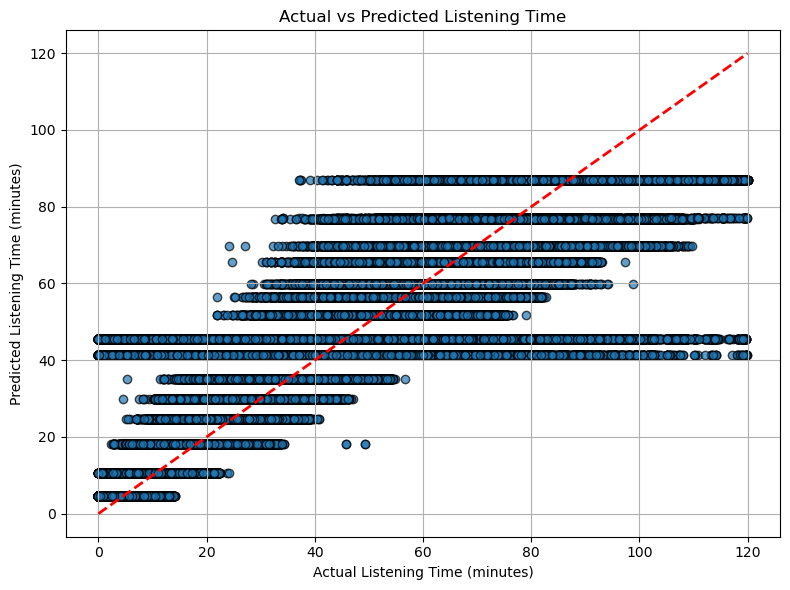

In [112]:
# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Listening Time (minutes)')
plt.ylabel('Predicted Listening Time (minutes)')
plt.title('Actual vs Predicted Listening Time')
plt.grid(True)
plt.tight_layout()
plt.show()

Because our data is not exceptionally large, I believe we can do a grid search to optimize our results and produce the best model without being too resource intensive.

In [113]:
# Define a grid of possible max_depth values to test
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Use negative MSE as the scoring metric (since GridSearchCV maximizes score)
scorer = metrics.make_scorer(metrics.root_mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, 
                           scoring=scorer, cv=5, n_jobs=-1,verbose=1)

# Fit on the training data
grid_search.fit(X_train, y_train)

# Best model and depth
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Evaluate the best model on validation data
y_pred_tuned = best_model.predict(X_test)
rmse_tuned = metrics.root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = metrics.r2_score(y_test, y_pred_tuned)

print(f"Tuned Root Mean Squared Error: {rmse_tuned:.2f}")
print(f"Tuned R² Score: {r2_tuned:.4f}")

Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}
Tuned Root Mean Squared Error: 13.31
Tuned R² Score: 0.7598


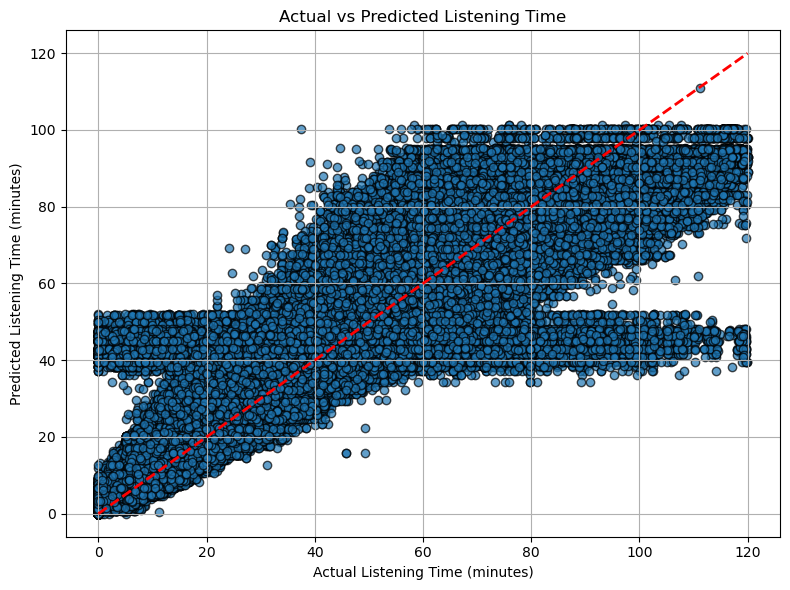

In [114]:
# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tuned, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Listening Time (minutes)')
plt.ylabel('Predicted Listening Time (minutes)')
plt.title('Actual vs Predicted Listening Time')
plt.grid(True)
plt.tight_layout()
plt.show()

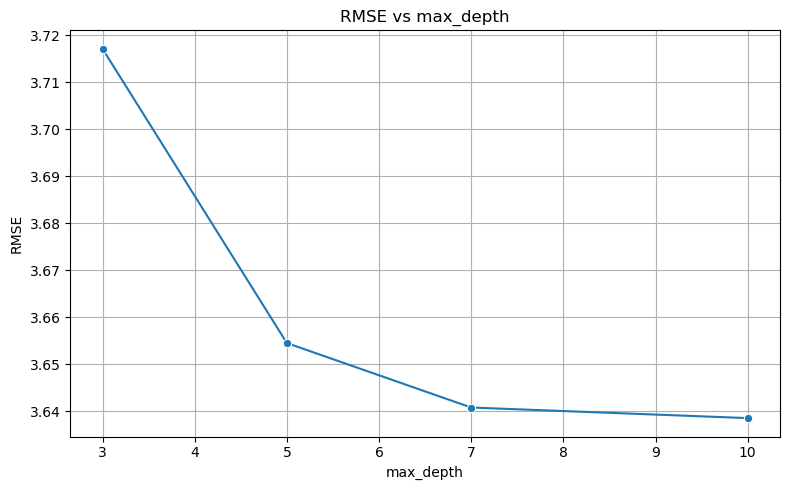

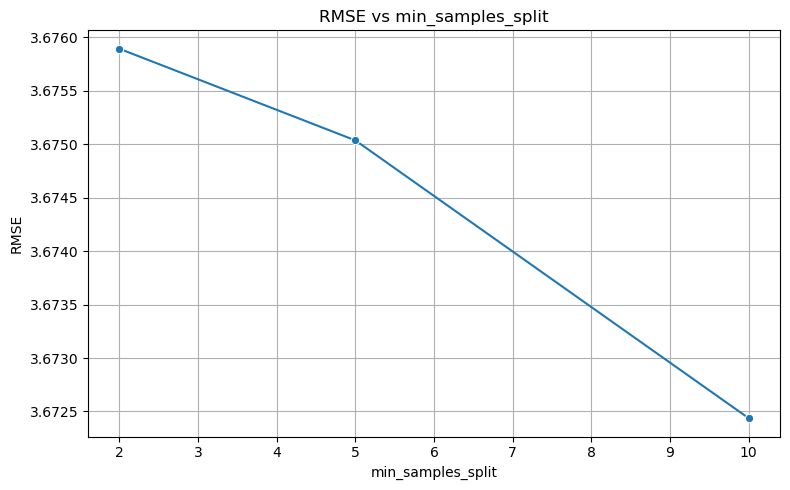

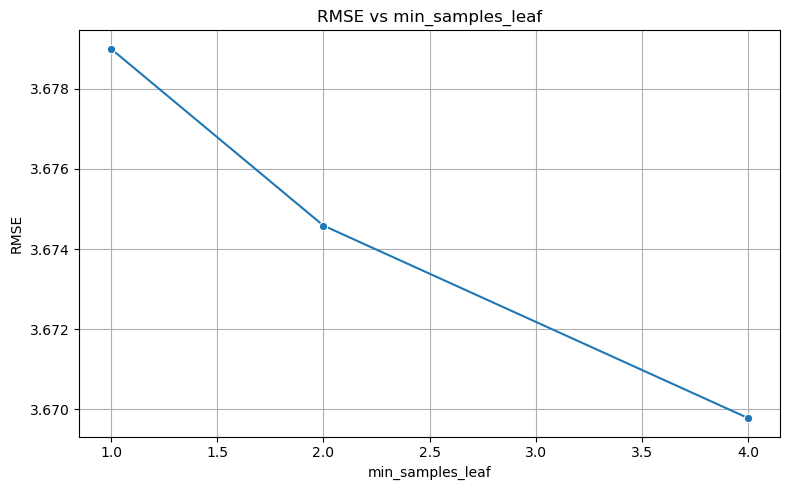

In [115]:
# Extract grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)
param_names = list(param_grid.keys())
# Convert 'mean_test_score' back to positive MSE (since it's negative)
results_df['mean_test_score'] = -results_df['mean_test_score']
# Compute RMSE from MSE
results_df['RMSE'] = results_df['mean_test_score'].apply(np.sqrt)

# Plot RMSE vs each hyperparameter
for param in param_names:
    # Extract the parameter values
    results_df[param] = results_df['params'].apply(lambda d: d[param])


    # Aggregate mean RMSE for each unique value of this parameter
    grouped = results_df.groupby(param)['RMSE'].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=param, y='RMSE', data=grouped, marker='o')
    plt.title(f'RMSE vs {param}')
    plt.ylabel('RMSE')
    plt.xlabel(param)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

While the training data does not have enough rows for it to be significant, if a larger dataset is used and computational efficiency matters than the optimal hyperparameters are: 
max_depth = 5
min_samples_split = 2
min_samples_leaf = 2

### Regressive Tree Model RMSE: 13.31

# Random Forest Model

In [116]:
# Build a basic random forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)

# Evaluate
rmse = metrics.root_mean_squared_error(y_test, rf_preds)
r2 = metrics.r2_score(y_test, rf_preds)

print(f"Random Forest RMSE: {rmse:.2f}")
print(f"Random Forest R² Score: {r2:.4f}")

Random Forest RMSE: 13.72
Random Forest R² Score: 0.7446


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


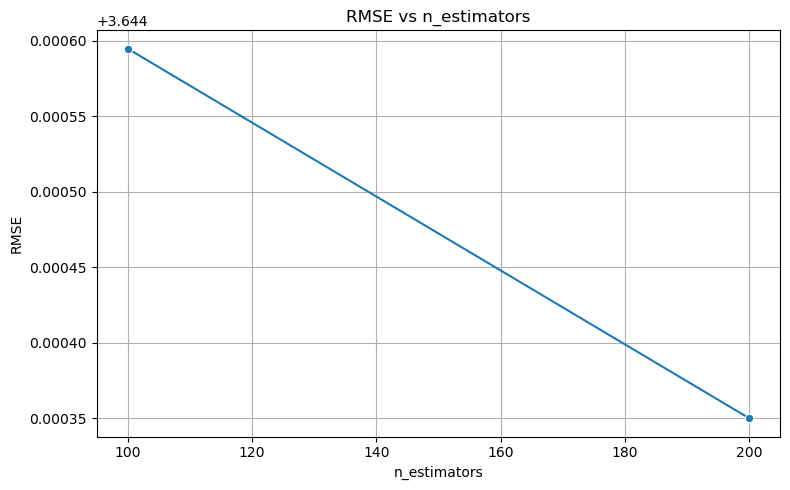

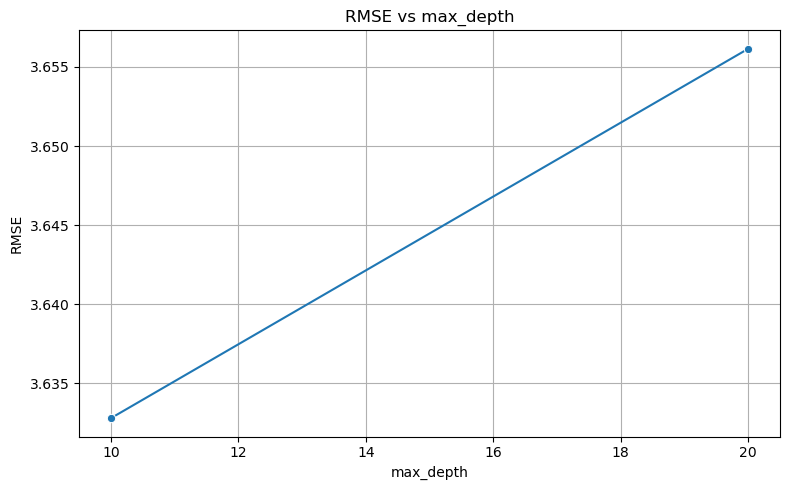

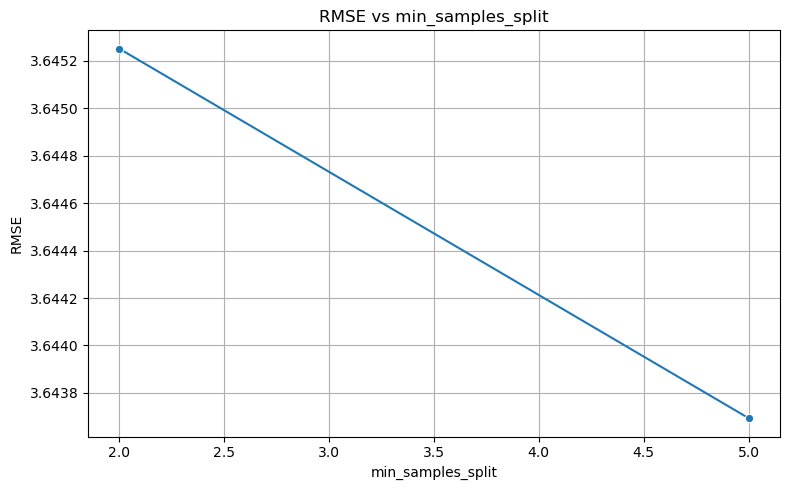

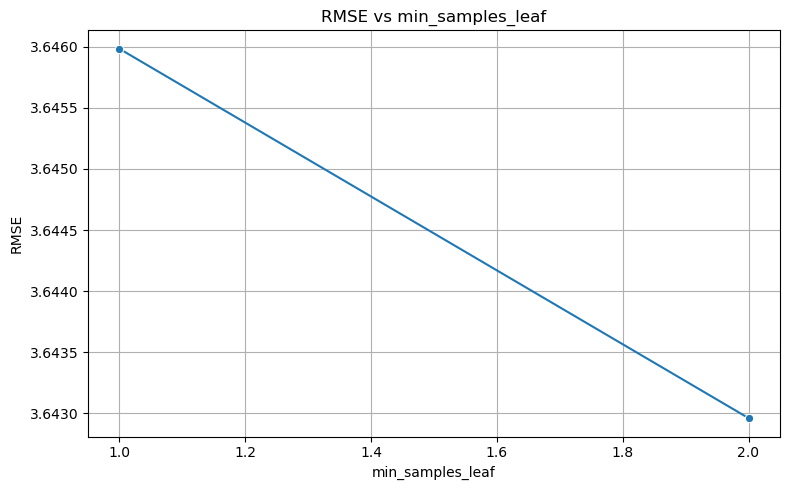

In [117]:
#create GridSearch param grid
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Set up the grid search
rf = RandomForestRegressor(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf,
                           param_grid=param_grid_rf,
                           scoring=scorer,
                           cv=5,
                           n_jobs=2,
                           verbose=1)
# Fit to training data
grid_search_rf.fit(X_train, y_train)
# Display best params to compare to charts
best_params_rf = grid_search_rf.best_params_
print(f"Best Parameters: {best_params_rf}")

# Extract grid search results into a DataFrame
rf_results_df = pd.DataFrame(grid_search_rf.cv_results_)
param_names = list(param_grid_rf.keys())
# Convert 'mean_test_score' back to positive MSE (since it's negative)
rf_results_df['mean_test_score'] = -rf_results_df['mean_test_score']
# Compute RMSE from MSE
rf_results_df['RMSE'] = rf_results_df['mean_test_score'].apply(np.sqrt)

# Plot RMSE vs each hyperparameter
for param in param_names:
    # Extract the parameter values
    rf_results_df[param] = rf_results_df['params'].apply(lambda d: d[param])


    # Aggregate mean RMSE for each unique value of this parameter
    grouped = rf_results_df.groupby(param)['RMSE'].mean().reset_index()

    # Plot
    plt.figure(figsize=(8, 5))
    sns.lineplot(x=param, y='RMSE', data=grouped, marker='o')
    plt.title(f'RMSE vs {param}')
    plt.ylabel('RMSE')
    plt.xlabel(param)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [118]:
# Best model and evaluation
best_rf = grid_search_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)
rmse = metrics.root_mean_squared_error(y_test, y_pred_rf)
r2 = metrics.r2_score(y_test, y_pred_rf)

print(f"Tuned Random Forest RMSE: {rmse:.2f}")
print(f"Tuned Random Forest R² Score: {r2:.4f}")

Tuned Random Forest RMSE: 13.26
Tuned Random Forest R² Score: 0.7614


# XG Boost

In [119]:
# Initialize and train the XGBoost Regressor
xg_reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=100,       # Number of boosting rounds (like number of trees)
    max_depth=3,            # Depth of each tree
    learning_rate=0.1       # Step size shrinkage
)
xg_reg.fit(X_train, y_train)

# Predict
xg_y_pred = xg_reg.predict(X_test)

# Evaluate
rmse = metrics.root_mean_squared_error(y_test, xg_y_pred)
r2 = metrics.r2_score(y_test, xg_y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost R² Score: {r2:.4f}")

XGBoost RMSE: 13.30
XGBoost R² Score: 0.7599


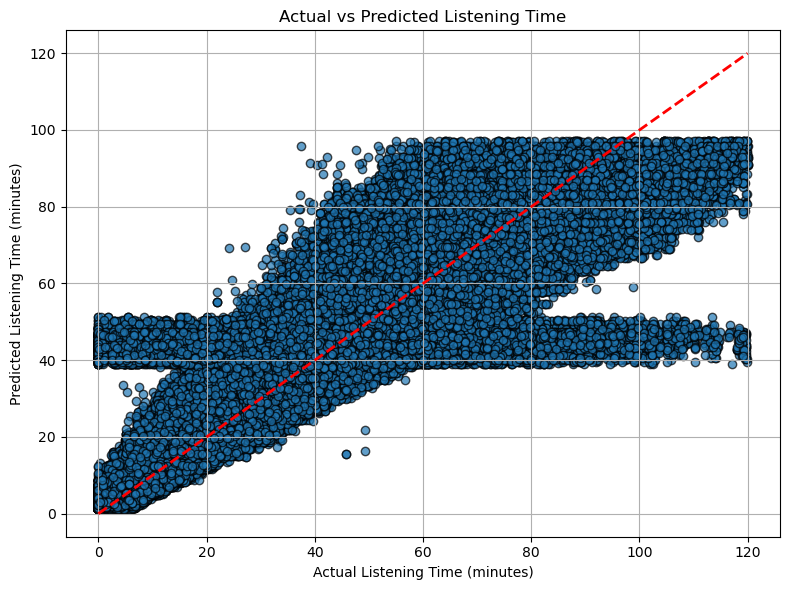

In [120]:
# Plot predicted vs actual
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xg_y_pred, edgecolor='k', alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Listening Time (minutes)')
plt.ylabel('Predicted Listening Time (minutes)')
plt.title('Actual vs Predicted Listening Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [121]:
# Define the parameter grid
param_grid_xg = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0]
}

# Set up the grid search
grid_search_xg = GridSearchCV(estimator=rf,
                           param_grid=param_grid_rf,
                           scoring=scorer,
                           cv=5,
                           n_jobs=2,
                           verbose=1)
# Fit to training data
grid_search_xg.fit(X_train, y_train)
# Display best params to compare to charts
best_params_xg = grid_search.best_params_
print(f"Best Parameters: {best_params_xg}")
# Extract grid search results into a DataFrame
xg_results_df = pd.DataFrame(grid_search_xg.cv_results_)
param_names_xg = list(param_grid_xg.keys())
# Convert 'mean_test_score' back to positive MSE (since it's negative)
xg_results_df['mean_test_score'] = -xg_results_df['mean_test_score']
# Compute RMSE from MSE
xg_results_df['RMSE'] = xg_results_df['mean_test_score'].apply(np.sqrt)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [122]:
# Extract the best model
best_xg = grid_search.best_estimator_

# Predict on test set
y_pred_xgb = best_xg.predict(X_test)

# Evaluate
rmse = metrics.root_mean_squared_error(y_test, y_pred_xgb)
r2 = metrics.r2_score(y_test, y_pred_xgb)

print(f"Tuned XGBoost RMSE: {rmse:.2f}")
print(f"Tuned XGBoost R² Score: {r2:.4f}")

Tuned XGBoost RMSE: 13.31
Tuned XGBoost R² Score: 0.7598


# Results

Tuned Decison Tree RMSE: 13.31

Tuned Random Forest RMSE: 13.26 *

Tuned XGBoost RMSE: 13.31

Our Tuned Random Forest is the most accurate model made. We will use this model to project onto the test data.

In [123]:
test_id = test
test = test.drop(columns='id')
X2 = test
full_labels = best_rf.predict(X2)
test_id['Listening_Time_minutes'] = full_labels

In [125]:
test_id = test_id[['id','Listening_Time_minutes']]
test_id.to_csv('/Users/sa12/Documents/Repositories/PredictPodcastListeningTime/submission.csv')